<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/meta_learningrateDecay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Create and inspect the data

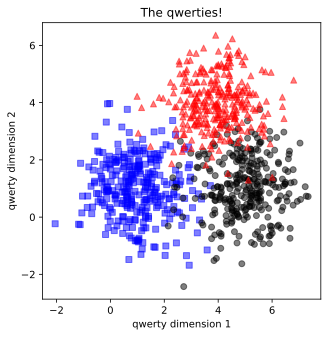

In [14]:
#create data
nPerClust=300
blur=1

A=[1,1]
B=[5,1]
C=[4,4]
#generate data
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c=[C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]
#true labels
labels_np=np.hstack((np.zeros((nPerClust)),np.ones((nPerClust)),2*np.ones((nPerClust))))
#concatanate into a matrix
data_np=np.hstack((a,b,c)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).long() #note:'long' format for CCE
#show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [15]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=.1)
#then convert them into pytorch datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#FINALLY, translate into dataloader objects
batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [16]:
print(f'there are {len(train_loader)}batches, each with {batchsize} samples')

there are 50batches, each with 16 samples


Create and Validate the model

In [24]:
#create a class for the model
def createTheQwertyNet(initialLR):
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      #input layer
      self.input=nn.Linear(2,8)
      ##hidden layer
      self.fc1=nn.Linear(8,8)
      ##output layer
      self.output=nn.Linear(8,3)
    def forward(self,x):
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=self.output(x)
      return x
   # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer and LR schedular
  optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
  stepsize=batchsize*len(train_loader)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)


  return net,lossfun,optimizer,scheduler





Explore the learning rate decay parameter


In [25]:
#create a network
net=createTheQwertyNet(.01)[0]
# a new optimizer
optimizer=torch.optim.SGD(net.parameters(),lr=.01)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=1/2)
for epoch in range(3):
  for batchnum in range(10):
    print(f'Batch{batchnum},epoch{epoch}:Lr={scheduler.get_last_lr()[0]}')
    scheduler.step()

Batch0,epoch0:Lr=0.01
Batch1,epoch0:Lr=0.01
Batch2,epoch0:Lr=0.01
Batch3,epoch0:Lr=0.01
Batch4,epoch0:Lr=0.01
Batch5,epoch0:Lr=0.005
Batch6,epoch0:Lr=0.005
Batch7,epoch0:Lr=0.005
Batch8,epoch0:Lr=0.005
Batch9,epoch0:Lr=0.005
Batch0,epoch1:Lr=0.0025
Batch1,epoch1:Lr=0.0025
Batch2,epoch1:Lr=0.0025
Batch3,epoch1:Lr=0.0025
Batch4,epoch1:Lr=0.0025
Batch5,epoch1:Lr=0.00125
Batch6,epoch1:Lr=0.00125
Batch7,epoch1:Lr=0.00125
Batch8,epoch1:Lr=0.00125
Batch9,epoch1:Lr=0.00125
Batch0,epoch2:Lr=0.000625
Batch1,epoch2:Lr=0.000625
Batch2,epoch2:Lr=0.000625
Batch3,epoch2:Lr=0.000625
Batch4,epoch2:Lr=0.000625
Batch5,epoch2:Lr=0.0003125
Batch6,epoch2:Lr=0.0003125
Batch7,epoch2:Lr=0.0003125
Batch8,epoch2:Lr=0.0003125
Batch9,epoch2:Lr=0.0003125


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


A FUNCTION that trains the model

In [26]:
from threading import current_thread
def function2trainTheModel(initialLR,toggleDynamicLR):
  #number of epochs
  numepochs=50
  #create a new model
  net,lossfun,optimizer,scheduler=createTheQwertyNet(initialLR)
  #initialize Losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  currentLR=[]
  #iterate over epochs
  for epochi in range(numepochs):
    #iterate over training batches
    #switch on training mode
    net.train()
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #step the learning-rate scheduler
      if toggleDynamicLR:
        scheduler.step()
      #loss from this batch
      batchLoss.append(loss.item())
      #compute accuracy over the training batch
      accuracyPct=100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      batchAcc.append(accuracyPct)

      currentLR.append(scheduler.get_last_lr()[0])
    #now that we have trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    #and get average losses across the batches
    losses[epochi]=np.mean(batchLoss)
    #test accuracy
    net.eval()
    X,y=next(iter(test_loader)) #extract X,y from test dataLoader
    with torch.no_grad(): #deactivates autograd
      yHat=net(X)
    #compute test accuracy
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    #epochs
  return trainAcc,testAcc,losses,net,currentLR

Test that the model really changes(sanity check)

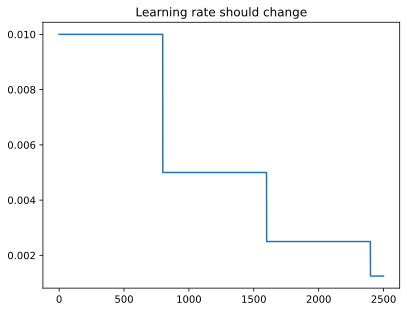

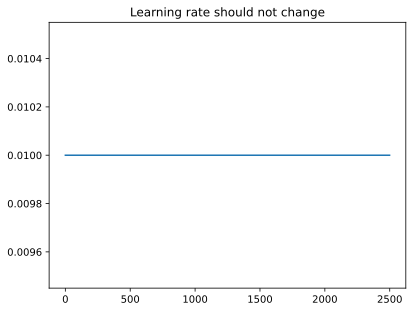

In [27]:
#test that the learning rate is really working
trainAcc,testAcc,losses,net,currentLR=function2trainTheModel(.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()
trainAcc,testAcc,losses,net,currentLR=function2trainTheModel(.01,False)
plt.plot(currentLR)
plt.title('Learning rate should not change')
plt.show()

Experiment

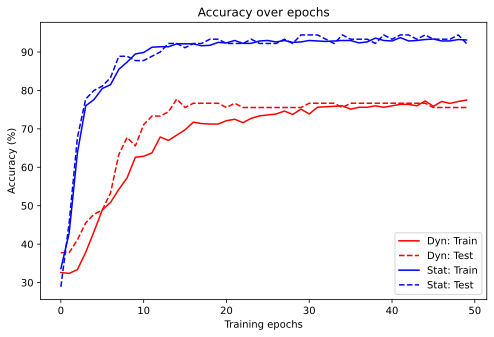

In [28]:

# now test with and without dynamic LR
trainAccDynamic,testAccDynamic,losses,net,currentLR = function2trainTheModel(.01,True)
trainAccStatic,testAccStatic,losses,net,currentLR   = function2trainTheModel(.01,False)

fig = plt.figure(figsize=(8,5))
plt.plot(trainAccDynamic,'r',label='Dyn: Train')
plt.plot(testAccDynamic,'r--',label='Dyn: Test')

plt.plot(trainAccStatic,'b',label='Stat: Train')
plt.plot(testAccStatic,'b--',label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()


Plot the results!